# 1. CNOT Binary Tree Fan-Out for GHZ State Generation

The generalized GHZ state in a $N$-qubit Hilbert space is defined as

$$ \ket{GHZ} = \frac{\ket{0}^{\otimes N} + \ket{1}^{\otimes N}}{\sqrt{2}}.$$

## Quick Summary

- Naive GHZ state preparation in a $N$-qubit system requires a circuit depth of $\mathcal{O}(N)$
- Using CNOT binary tree fan-out and assuming ideal qubit connectivity, the circuit depth can in principle be reduced to $\mathcal{O}(\text{log}_2(N))$ by parallelizing the required CNOT gates
- We implement optimal CNOT binary tree fan-out for GHZ state generation given a graph of any IBM backend
- We demonstrate significant reduction of the two-qubit gate circuit depth for GHZ state generation comparing our method to the Qiskit transpiler result (up to 80 %)
- On Torino backend two-qubit gate depth can be reduced to scale as $\mathcal{O}(\sqrt{N})$

## Introduction
Starting with the initial state $\ket{0 \dotsm 0}$, the GHZ state can be deterministically prepared with the following circuit:

In [2]:
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOslo, FakeSingaporeV2
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler import generate_preset_pass_manager
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit, transpile

/Users/samizweidler/Documents/ETH/4_6_Master/6.Jahr/Qiskit_Hackathon_June/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


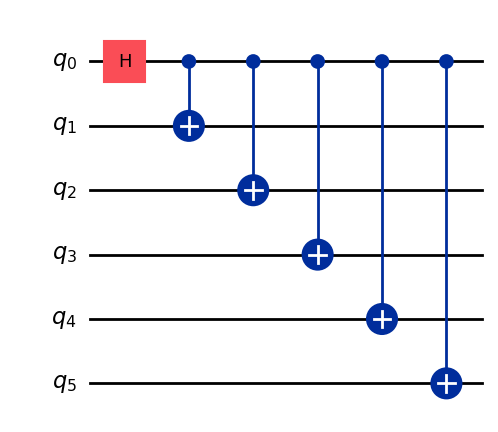

In [3]:
# example for n=6 qubits

def naive_ghz_V1(n=6):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(0, i + 1)
    return qc

qc1 = naive_ghz_V1()
qc1.draw('mpl')

This circuit can be rewritten as follows (still considering the initial state $\ket{0 \dotsm 0}$)

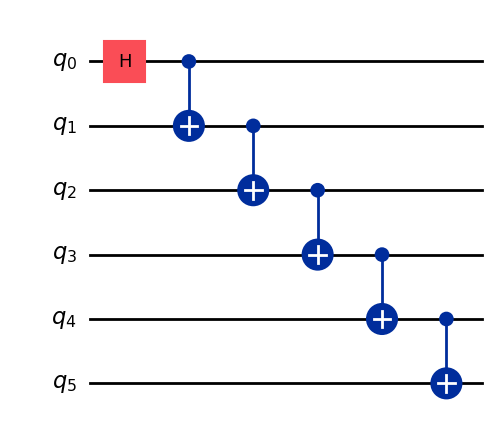

In [4]:
# example for n=6 qubits

def naive_ghz_V2(n=6):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

qc2 = naive_ghz_V2()
qc2.draw('mpl')

The latter circuit is compatible with a QPU geometry with only two nearest neighbours per qubit, i.e. with any IBM Quantum Backend.

## Idea: CNOT Binary Tree Fan-Out

In both examplary circuits, we recognize that we can rewrite them also in the following way

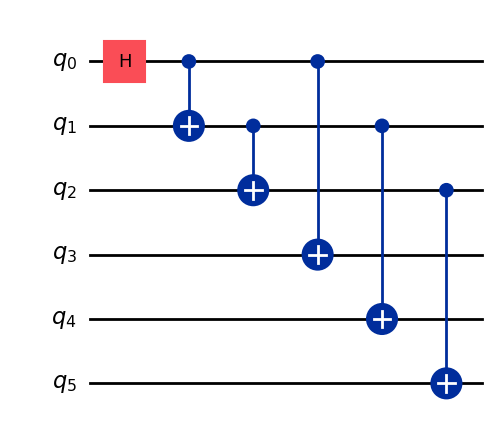

In [5]:
qc3 = QuantumCircuit(6)

qc3.h(0)
qc3.cx(0, 1)
qc3.cx(1, 2)
qc3.cx(0, 3)
qc3.cx(1, 4)
qc3.cx(2, 5)

qc3.draw('mpl')

Notably, the last three CNOT gates can be implemented in parallel, reducing the 2Q-circuit depth from 5 to 3 in this example. 

This parrallelization strategy (CNOT binary tree fan-out) can be generalized to efficiently generate GHZ in a many-qubit system. The number of CNOT gates that can be executed in parallel grows as $3 \cdot 2^{M}$ for every step, which leads to a circuit depth that is logarithmic in the number of qubits $N$.

## Implementation

The fan-out strategy described above ideally requires exponentially growing qubit connectivity. To adapt the strategy for a given IBM backend, we constantly evaluate all non-entangled nearest neighbours in qubit connectivity graph and maximally parallelize the CNOT gate execution.

In [6]:
def optimized_ghz_circuit(n, backend):

    coupling = backend.configuration().coupling_map  # List of [control, target] edges

    # Convert to networkx.Graph
    G = nx.Graph()
    G.add_edges_from(coupling)

    seen = set()

    qc = QuantumCircuit(len(G.nodes))

    qc.h(0)  # Apply Hadamard to the first qubit
    seen.add(0)
    boundary = {0}
    while len(seen) < n:
        new_boundary = set()
        for i in boundary:
            for j in G.neighbors(i):
                if j not in seen:
                    qc.cx(i, j)
                    seen.add(j)
                    new_boundary.add(j)
        boundary = new_boundary
    
    return qc

## Evaluation

Evaluate how the two-qubit gate circuit depth scales with the number of qubits that are part of the GHZ state. (RUNS 2 min.)

In order to spare time, we stored the computed depths in lists (set run_eval to False)

Compute naive circuit V1, naive circuit V2, and optimized circuit employing the fan-out strategy. Transpile all circuits. Evaluate two-qubit gate depth for all transpiled circuits.

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler import generate_preset_pass_manager

n_list = np.arange(3,31) 

two_Q_depth_1 = []
two_Q_depth_2 = []
two_Q_depth_3 = []

run_eval = False

if run_eval:
    for n in n_list:
    
        backend = FakeTorino() 

        # naive 1
        qc1 = naive_ghz_V1(n)

        # naive 2
        qc2 = naive_ghz_V2(n)

        # optimized
        qc3 = optimized_ghz_circuit(n, backend)

        # transpile
        qc1_t = transpile(qc1, backend=backend, optimization_level=3)
        qc2_t = transpile(qc2, backend=backend, optimization_level=3)
        qc3_t = transpile(qc3, backend=backend, optimization_level=3)

        two_Q_depth_1.append(qc1_t.depth(lambda op: len(op.qubits) == 2))
        two_Q_depth_2.append(qc2_t.depth(lambda op: len(op.qubits) == 2))
        two_Q_depth_3.append(qc3_t.depth(lambda op: len(op.qubits) == 2))

else:
    # Precomputed values for two-qubit gate depths
    two_Q_depth_1 = [2, 3, 7, 11, 14, 16, 17, 22, 24, 33, 32, 36, 38, 44, 41, 47, 37, 53, 53, 56, 61, 71, 72, 74, 75, 89, 86, 83]
    two_Q_depth_2 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    two_Q_depth_3 = [2, 3, 3, 4, 4, 5, 5, 7, 7, 7, 7, 8, 8, 8, 10, 10, 10, 10, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13]

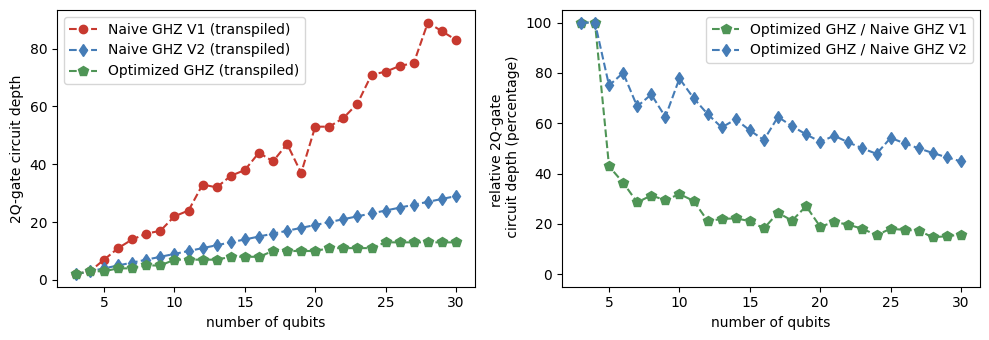

In [14]:
import matplotlib.pyplot as plt

red = (199/255, 57/255, 47/255)
blue = (69/255, 124/255, 182/255)
green = (79/255, 149/255, 86/255)
purple = (151/255, 142/255, 208/255)


fig, ax = plt.subplots(1,2, figsize=(10, 3.5))

ax[0].plot(n_list, two_Q_depth_1, label='Naive GHZ V1 (transpiled)', marker='o', color = red, linestyle= 'dashed', markersize=6)
ax[0].plot(n_list, two_Q_depth_2, label='Naive GHZ V2 (transpiled)', marker='d', color = blue, linestyle= 'dashed', markersize=6)
ax[0].plot(n_list, two_Q_depth_3, label='Optimized GHZ (transpiled)', marker='p', color = green, linestyle= 'dashed', markersize=7)
# reduction in depth (percentage)

ax[1].plot(n_list, np.array(two_Q_depth_3) / np.array(two_Q_depth_1)*100, label='Optimized GHZ / Naive GHZ V1', marker='p', color = green, linestyle= 'dashed', markersize=7)
ax[1].plot(n_list, np.array(two_Q_depth_3) / np.array(two_Q_depth_2)*100, label='Optimized GHZ / Naive GHZ V2', marker='d', color = blue, linestyle= 'dashed', markersize=6)



ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, shadow=True)

ax[0].set_xlabel('number of qubits')
ax[0].set_ylabel('2Q-gate circuit depth')
ax[0].legend()

ax[1].set_xlabel('number of qubits')
ax[1].set_ylabel('relative 2Q-gate \n circuit depth (percentage)')
ax[1].legend()

ax[1].set_ylim(-5, 105)

fig.set_tight_layout(True)
fig.savefig('ghz_depths.png', bbox_inches='tight', dpi = 400)

# Results

- Development of a pre-processing step that optimizes the circuit specific to GHZ state generation on a given IBM backend
- Employs CNOT binary tree fan-out reducing two-qubit gate circuit depth significantly below $\mathcal{O}(N)$ for $N$ qubits
- Lower bound for two-qubit gate circuit depth: $\mathcal{O}(\text{log}_2(N))$; attained for optimal qubit connectivity on QPU
- Two-qubit circuit depth scales like $\mathcal{O}(\sqrt{N})$ on a square lattice
- Demonstrated reduction of two-qubit gate circuit depth of up to 80 % (for N = 30 and comparing the optimized GHZ circuit to the V1 circuit)
- Methodology can be generalized to other CNOT ladder circuit structures

# 2. Resource pruning

In [24]:
# load in libraries
import numpy as np
import networkx as nx # represent the connectivity of the qubits as a graph 

# from qiskit we need:
# a simulated 27-qubit quantum computer, here FakeMontrealV2 --> stand-in for a real device, providing us also the qubit connectivity and error rates.
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2, FakeMarrakesh, FakeQuebec, FakeTorino
from qiskit import QuantumCircuit, transpile
from qiskit import visualization
# CouplingMap defines which physical qubits are connected 
from qiskit.transpiler import CouplingMap

# for plotting
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid', 'high-contrast'])

@misc{waring2024noiseawareutilityoptimization,
      title={Noise Aware Utility Optimization of NISQ Devices}, 
      author={Jean-Baptiste Waring and Christophe Pere and Sebastien Le Beux},
      year={2024},
      eprint={2402.08226},
      archivePrefix={arXiv},
      primaryClass={quant-ph},
      url={https://arxiv.org/abs/2402.08226}, 
}

## main functions

*get_simulated_backend_properties*: mimics fetching the latest calibration data from the device proceeds as follows
1. retrieve the properties of the backend (e.g. the error rates) and the coupling map
2. create two dictionaries for the CNOT and readout errors
3. loop through each connection in the coupling map and store the associated CNOT gate errors
4. loop through every qubit and store the measurement error
5. returns a single dictionary containing all vital data

In [17]:
def get_simulated_backend_properties(backend):
    """
    Fetches and organizes properties from a qiskit backend.
    """
    properties = backend.properties()
    config = backend.configuration()
    coupling_map = backend.configuration().coupling_map


    # get native gate set
    native_two_qubit_gate = None
    for gate_property in properties.gates:
        # find a gate that acts on two qubits
        if len(gate_property.qubits) == 2:
            native_two_qubit_gate = gate_property.gate
            break  # found the first one, so we can stop

    if native_two_qubit_gate is None:
        print("Warning: Could not determine a calibrated native two-qubit gate. Defaulting to 'cx'.")
        native_two_qubit_gate = 'cx'
        
    print(f"Identified native two-qubit entangling gate: '{native_two_qubit_gate}'")

    # organize error rates for easy access
    cnot_errors = {}
    readout_errors = {}

    # get cnot errors
    for edge in coupling_map:
        try:
            error = properties.gate_error(native_two_qubit_gate, edge)
            cnot_errors[tuple(edge)] = error
        except Exception:
            # assign a default high error if not found
            cnot_errors[tuple(edge)] = 0.1 

    # get single qubit readout errors
    for qubit in range(backend.configuration().n_qubits):
        try:
            error = properties.readout_error(qubit)
            readout_errors[qubit] = error
        except Exception:
            readout_errors[qubit] = 0.1 # assign a default high error if not found
            
    return {
        'n_qubits': backend.configuration().n_qubits,
        'coupling_map': coupling_map,
        'cnot_errors': cnot_errors,
        'readout_errors': readout_errors,
        'basis_gates': config.basis_gates
    }, native_two_qubit_gate

*prune_resources*: heart of the approach, namely take he full hardware properties + user-defined error thresholds and return a smaller, higher quality "partition" of the original hardware. 
1. convert the coupling map of the device to a networkx graph
2. remove any qubit (i.e. node) with a higher readout error than the respective threshold value
3. remove any connection (i.e. edge) with a higher CNOT error than the respective threshold value
4. after pruning, the graph might be potentially fragmented into several disconnected pieces $\to$ select the single largest connected component as the optimal partition for execution
5. return the list of qubits in this best partition and the corresponding new, smaller coupling map

In [18]:
def prune_resources(backend_properties, cnot_error_threshold, readout_error_threshold):
    """
    prunes qubits and connections based on user-defined error thresholds, as described also in arXiv:2402.08226v2
    """
    # create graph
    full_coupling_map = backend_properties['coupling_map']
    n_qubits = backend_properties['n_qubits']
    graph = nx.Graph()
    graph.add_nodes_from(range(n_qubits))
    graph.add_edges_from(full_coupling_map)

    # single qubit readout error criterion
    admissible_qubits = {q for q, err in backend_properties['readout_errors'].items() if err < readout_error_threshold}
    
    nodes_to_remove = set(range(n_qubits)) - admissible_qubits
    graph.remove_nodes_from(nodes_to_remove)

    # CNOT error criterion
    edges_to_remove = []
    for u, v in graph.edges():
        cnot_error = backend_properties['cnot_errors'].get((u, v)) or backend_properties['cnot_errors'].get((v, u))
        if cnot_error is None or cnot_error > cnot_error_threshold:
            edges_to_remove.append((u, v))
            
    graph.remove_edges_from(edges_to_remove)

    # find the largest connected component
    if not list(nx.connected_components(graph)):
        print("Warning: No partition found for the given thresholds. Check if thresholds are too strict.")
        return [], []
        
    largest_cc = max(nx.connected_components(graph), key=len)
    pruned_qubit_list = sorted(list(largest_cc))
    
    # Create the new coupling map from the largest partition
    pruned_coupling_map = [edge for edge in graph.edges if edge[0] in pruned_qubit_list and edge[1] in pruned_qubit_list]

    print(f"Pruning complete. Original qubits: {n_qubits}. Pruned partition has {len(pruned_qubit_list)} qubits.")
    
    return pruned_qubit_list, pruned_coupling_map

instead of doing a costly simulations, we calculate here expected fidelity measured based on the error rates of the CNOT gates used in the final circuit

In [19]:
# ---  METRIC 1: Average CNOT Error ---
def calculate_average_cnot_error(transpiled_circuit, cnot_errors, native_two_qubit_gate):
    """calculates the average error of all CNOT gates in the circuit."""
    total_error_sum = 0
    num_cnots = 0
    for instr in transpiled_circuit.data:
        if instr.operation.name == native_two_qubit_gate:
            num_cnots += 1
            qubits = tuple(transpiled_circuit.find_bit(q).index for q in instr.qubits)
            error = cnot_errors.get(qubits) or cnot_errors.get(qubits[::-1])

            # --- DEBUGGING  ---
            if error is not None and error >= 1.0:
                print(f"DEBUG: Found a 100% error rate (error={error}) for CNOT on qubits {qubits}")

            if error is not None:
                total_error_sum += error
    
    if num_cnots == 0:
        return 0.0
    return total_error_sum / num_cnots

# ---  METRIC 2: Total CNOT Infidelity ---
def calculate_total_cnot_infidelity(transpiled_circuit, cnot_errors, native_two_qubit_gate):
    """calculates the sum of all CNOT gate errors in the circuit."""
    total_error_sum = 0
    for instr in transpiled_circuit.data:
        if instr.operation.name == native_two_qubit_gate:
            qubits = tuple(transpiled_circuit.find_bit(q).index for q in instr.qubits)
            error = cnot_errors.get(qubits) or cnot_errors.get(qubits[::-1])
            if error is not None:
                total_error_sum += error
    return total_error_sum


### Main code: definitions (here user input is required)

In [20]:
# define the noisy simulator device - USER INPUT REQUIRED!!!
backend = FakeTorino()
backend_props, native_two_qubit_gate = get_simulated_backend_properties(backend)
print(f"Using backend: {backend.name} ({backend_props['n_qubits']} qubits)")

Identified native two-qubit entangling gate: 'cz'
Using backend: fake_torino (133 qubits)


In [21]:
# define user error thresholds - USER INPUT REQUIRED!!!
CNOT_THRESHOLD = 0.015 # maximum error allowed for CNOTs
READOUT_THRESHOLD = 0.10 # maximum error allowed for single qubit readouts

print(f"CNOT error threshold set to: {CNOT_THRESHOLD:.4f}")
print(f"Readout error threshold set to: {READOUT_THRESHOLD:.4f}\n")

CNOT error threshold set to: 0.0150
Readout error threshold set to: 0.1000



In [22]:
# transpilation parameters - USER INPUT REQUIRED!!!
optimization_level = 3
seed_transpiler = 42

### Data aquisition and plotting

In [25]:
cnot_counts_baseline = []
cnot_counts_pruned = []

infidelities_baseline = []
infidelities_pruned = []


depths_baseline = []
depths_pruned = []

for n in range(2,40):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i + 1)
    
    pruned_qubits, pruned_cm_list = prune_resources(backend_props, CNOT_THRESHOLD, READOUT_THRESHOLD)
    if len(pruned_qubits) < n:
        print(f"Execution stopped: The pruned partition has only {len(pruned_qubits)} qubits, which is not enough for an {n}-qubit circuit.")
        print("Try relaxing the CNOT or readout error thresholds.")

    basis_gates = backend_props['basis_gates']

    full_coupling_map = CouplingMap(backend_props['coupling_map'])
    transpiled_baseline = transpile(qc, coupling_map=full_coupling_map, basis_gates=basis_gates,
                                    optimization_level=optimization_level, seed_transpiler=seed_transpiler)
    
    pruned_coupling_map = CouplingMap(pruned_cm_list)
    initial_layout_pruned = pruned_qubits[:n]
    
    transpiled_pruned = transpile(qc, 
                                  coupling_map=pruned_coupling_map, 
                                  basis_gates=basis_gates,
                                  initial_layout=initial_layout_pruned,
                                  optimization_level=optimization_level,
                                  seed_transpiler=seed_transpiler)

    avg_error_baseline = calculate_average_cnot_error(transpiled_baseline, backend_props['cnot_errors'], native_two_qubit_gate)
    infidelity_baseline = calculate_total_cnot_infidelity(transpiled_baseline, backend_props['cnot_errors'], native_two_qubit_gate)
    depth_baseline = transpiled_baseline.depth()
    cnot_count_baseline = transpiled_baseline.count_ops().get(native_two_qubit_gate, 0)
    
    
    avg_error_pruned = calculate_average_cnot_error(transpiled_pruned, backend_props['cnot_errors'], native_two_qubit_gate)
    infidelity_pruned = calculate_total_cnot_infidelity(transpiled_pruned, backend_props['cnot_errors'], native_two_qubit_gate)
    depth_pruned = transpiled_pruned.depth()
    cnot_count_pruned = transpiled_pruned.count_ops().get(native_two_qubit_gate, 0)

    cnot_counts_baseline.append(cnot_count_baseline)
    cnot_counts_pruned.append(cnot_count_pruned)

    infidelities_baseline.append(infidelity_baseline)
    infidelities_pruned.append(infidelity_pruned)

    depths_baseline.append(depth_baseline)
    depths_pruned.append(depth_pruned)

Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (15, 19)
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (15, 19)
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (19, 20)
Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (15, 19)
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (19, 20)
Pruning

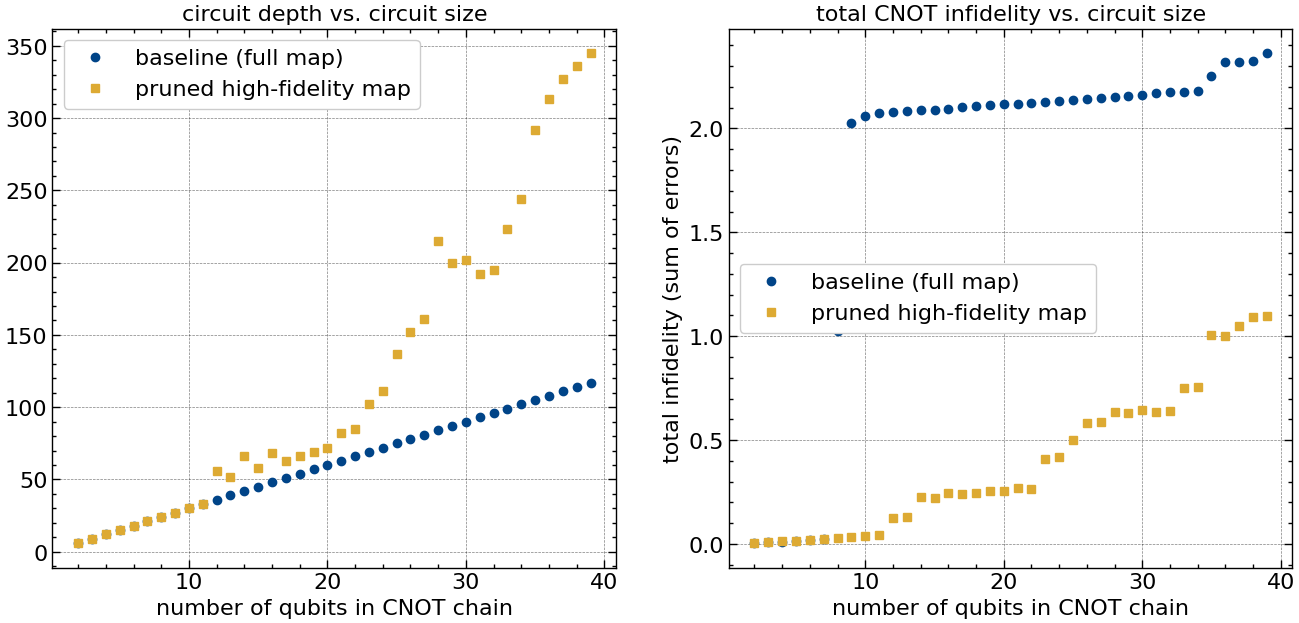

In [26]:
plot_qubit_range = range(2, 2 + len(infidelities_baseline))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# plot 1: CNOT count
ax1.plot(plot_qubit_range, depths_baseline, 'o', label='baseline (full map)')
ax1.plot(plot_qubit_range, depths_pruned, 's', label='pruned high-fidelity map')
ax1.set_xlabel('number of qubits in CNOT chain', fontsize=16)
ax1.set_title('circuit depth vs. circuit size', fontsize=16)
ax1.legend()

# plot 2: Total infidelity
ax2.plot(plot_qubit_range, infidelities_baseline, 'o', label='baseline (full map)')
ax2.plot(plot_qubit_range, infidelities_pruned, 's', label='pruned high-fidelity map')
ax2.set_xlabel('number of qubits in CNOT chain', fontsize=16)
ax2.set_ylabel('total infidelity (sum of errors)', fontsize=16)
ax2.set_title('total CNOT infidelity vs. circuit size', fontsize=16)
ax2.legend()


plt.show()

### deeper analysis for n = 20

In [27]:
# how many qubits does our circuit require / qubits in register - USER INPUT REQUIRED!!!
n = 20 # number of qubits

# define the quantum circuit - USER INPUT REQUIRED!!!
qc = QuantumCircuit(n)
#qc.h(0)
for i in range(n-1):
    qc.cx(i, i + 1)

In [28]:
pruned_qubits, pruned_cm_list = prune_resources(backend_props, CNOT_THRESHOLD, READOUT_THRESHOLD)

if len(pruned_qubits) < n:
    print(f"Execution stopped: The pruned partition has only {len(pruned_qubits)} qubits, which is not enough for an {n}-qubit circuit.")
    print("Try relaxing the CNOT or readout error thresholds.")

Pruning complete. Original qubits: 133. Pruned partition has 70 qubits.


In [29]:
# transipilation of full and pruned circuit

basis_gates = backend_props['basis_gates']

full_coupling_map = CouplingMap(backend_props['coupling_map'])
transpiled_baseline = transpile(qc, coupling_map=full_coupling_map, basis_gates=basis_gates,
                                optimization_level=optimization_level, seed_transpiler=seed_transpiler)

pruned_coupling_map = CouplingMap(pruned_cm_list)
initial_layout_pruned = pruned_qubits[:n]

transpiled_pruned = transpile(qc, 
                              coupling_map=pruned_coupling_map, 
                              basis_gates=basis_gates,
                              initial_layout=initial_layout_pruned,
                              optimization_level=optimization_level,
                              seed_transpiler=seed_transpiler)

In [30]:
# main results

# Baseline calculations
avg_error_baseline = calculate_average_cnot_error(transpiled_baseline, backend_props['cnot_errors'], native_two_qubit_gate)
infidelity_baseline = calculate_total_cnot_infidelity(transpiled_baseline, backend_props['cnot_errors'], native_two_qubit_gate)

# Pruned calculations
avg_error_pruned = calculate_average_cnot_error(transpiled_pruned, backend_props['cnot_errors'], native_two_qubit_gate)
infidelity_pruned = calculate_total_cnot_infidelity(transpiled_pruned, backend_props['cnot_errors'], native_two_qubit_gate)

print("\n--- Transpilation and Fidelity Results (Robust Comparison) ---")
print("="*60)
print("Baseline (Full Device Map)")
print("="*60)
print(f"Number of CNOTs: {transpiled_baseline.count_ops().get(native_two_qubit_gate, 0)}")
print(f"Average CNOT Error: {avg_error_baseline:.4f} (Lower is better)")
print(f"Total CNOT Infidelity (Error Sum): {infidelity_baseline:.4f} (Lower is better)")

print("\n" + "="*60)
print("Our Method (Pruned High-Fidelity Map)")
print("="*60)
print(f"Number of CNOTs: {transpiled_pruned.count_ops().get(native_two_qubit_gate, 0)}")
print(f"Average CNOT Error: {avg_error_pruned:.4f} (Lower is better)")
print(f"Total CNOT Infidelity (Error Sum): {infidelity_pruned:.4f} (Lower is better)")
print("="*60)


print("\n--- Conclusion ---")
if avg_error_pruned < avg_error_baseline:
    print("The pruned method successfully produced a circuit with a lower average CNOT error.")
    print("This is because the transpiler was forced to use connections with lower CNOT error rates.")
else:
    print("No improvement observed. This can happen if the original transpilation")
    print("already found an optimal mapping, or if the pruning was too aggressive and led to more SWAP gates.")

DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (15, 19)
DEBUG: Found a 100% error rate (error=1) for CNOT on qubits (19, 20)

--- Transpilation and Fidelity Results (Robust Comparison) ---
Baseline (Full Device Map)
Number of CNOTs: 19
Average CNOT Error: 0.1114 (Lower is better)
Total CNOT Infidelity (Error Sum): 2.1164 (Lower is better)

Our Method (Pruned High-Fidelity Map)
Number of CNOTs: 54
Average CNOT Error: 0.0047 (Lower is better)
Total CNOT Infidelity (Error Sum): 0.2558 (Lower is better)

--- Conclusion ---
The pruned method successfully produced a circuit with a lower average CNOT error.
This is because the transpiler was forced to use connections with lower CNOT error rates.


#### visualization for n = 20

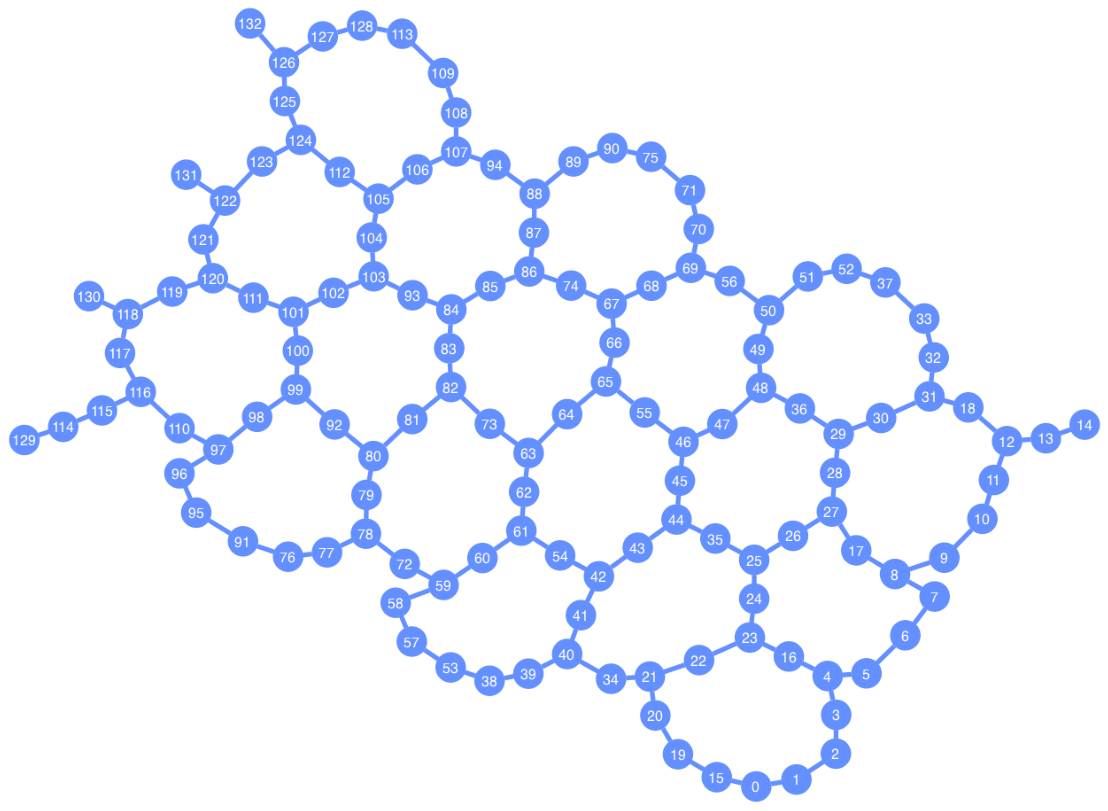

In [31]:
visualization.plot_coupling_map(full_coupling_map.size(), qubit_coordinates=None, coupling_map=full_coupling_map.get_edges())

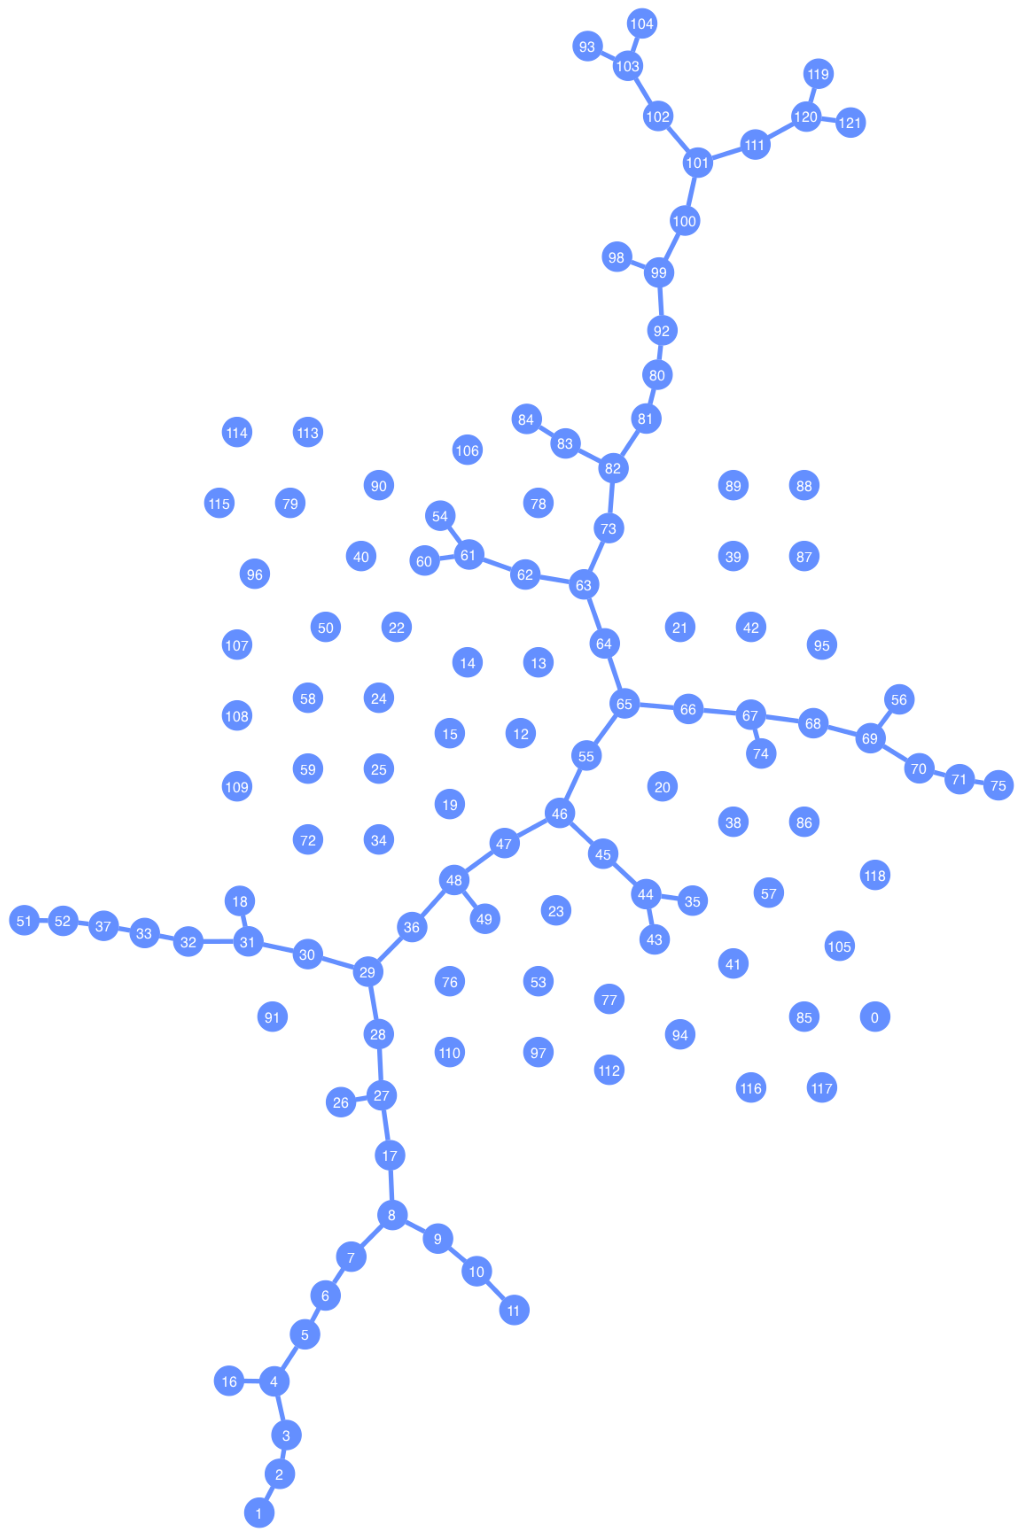

In [32]:
visualization.plot_coupling_map(pruned_coupling_map.size(), qubit_coordinates=None, coupling_map=pruned_coupling_map.get_edges())

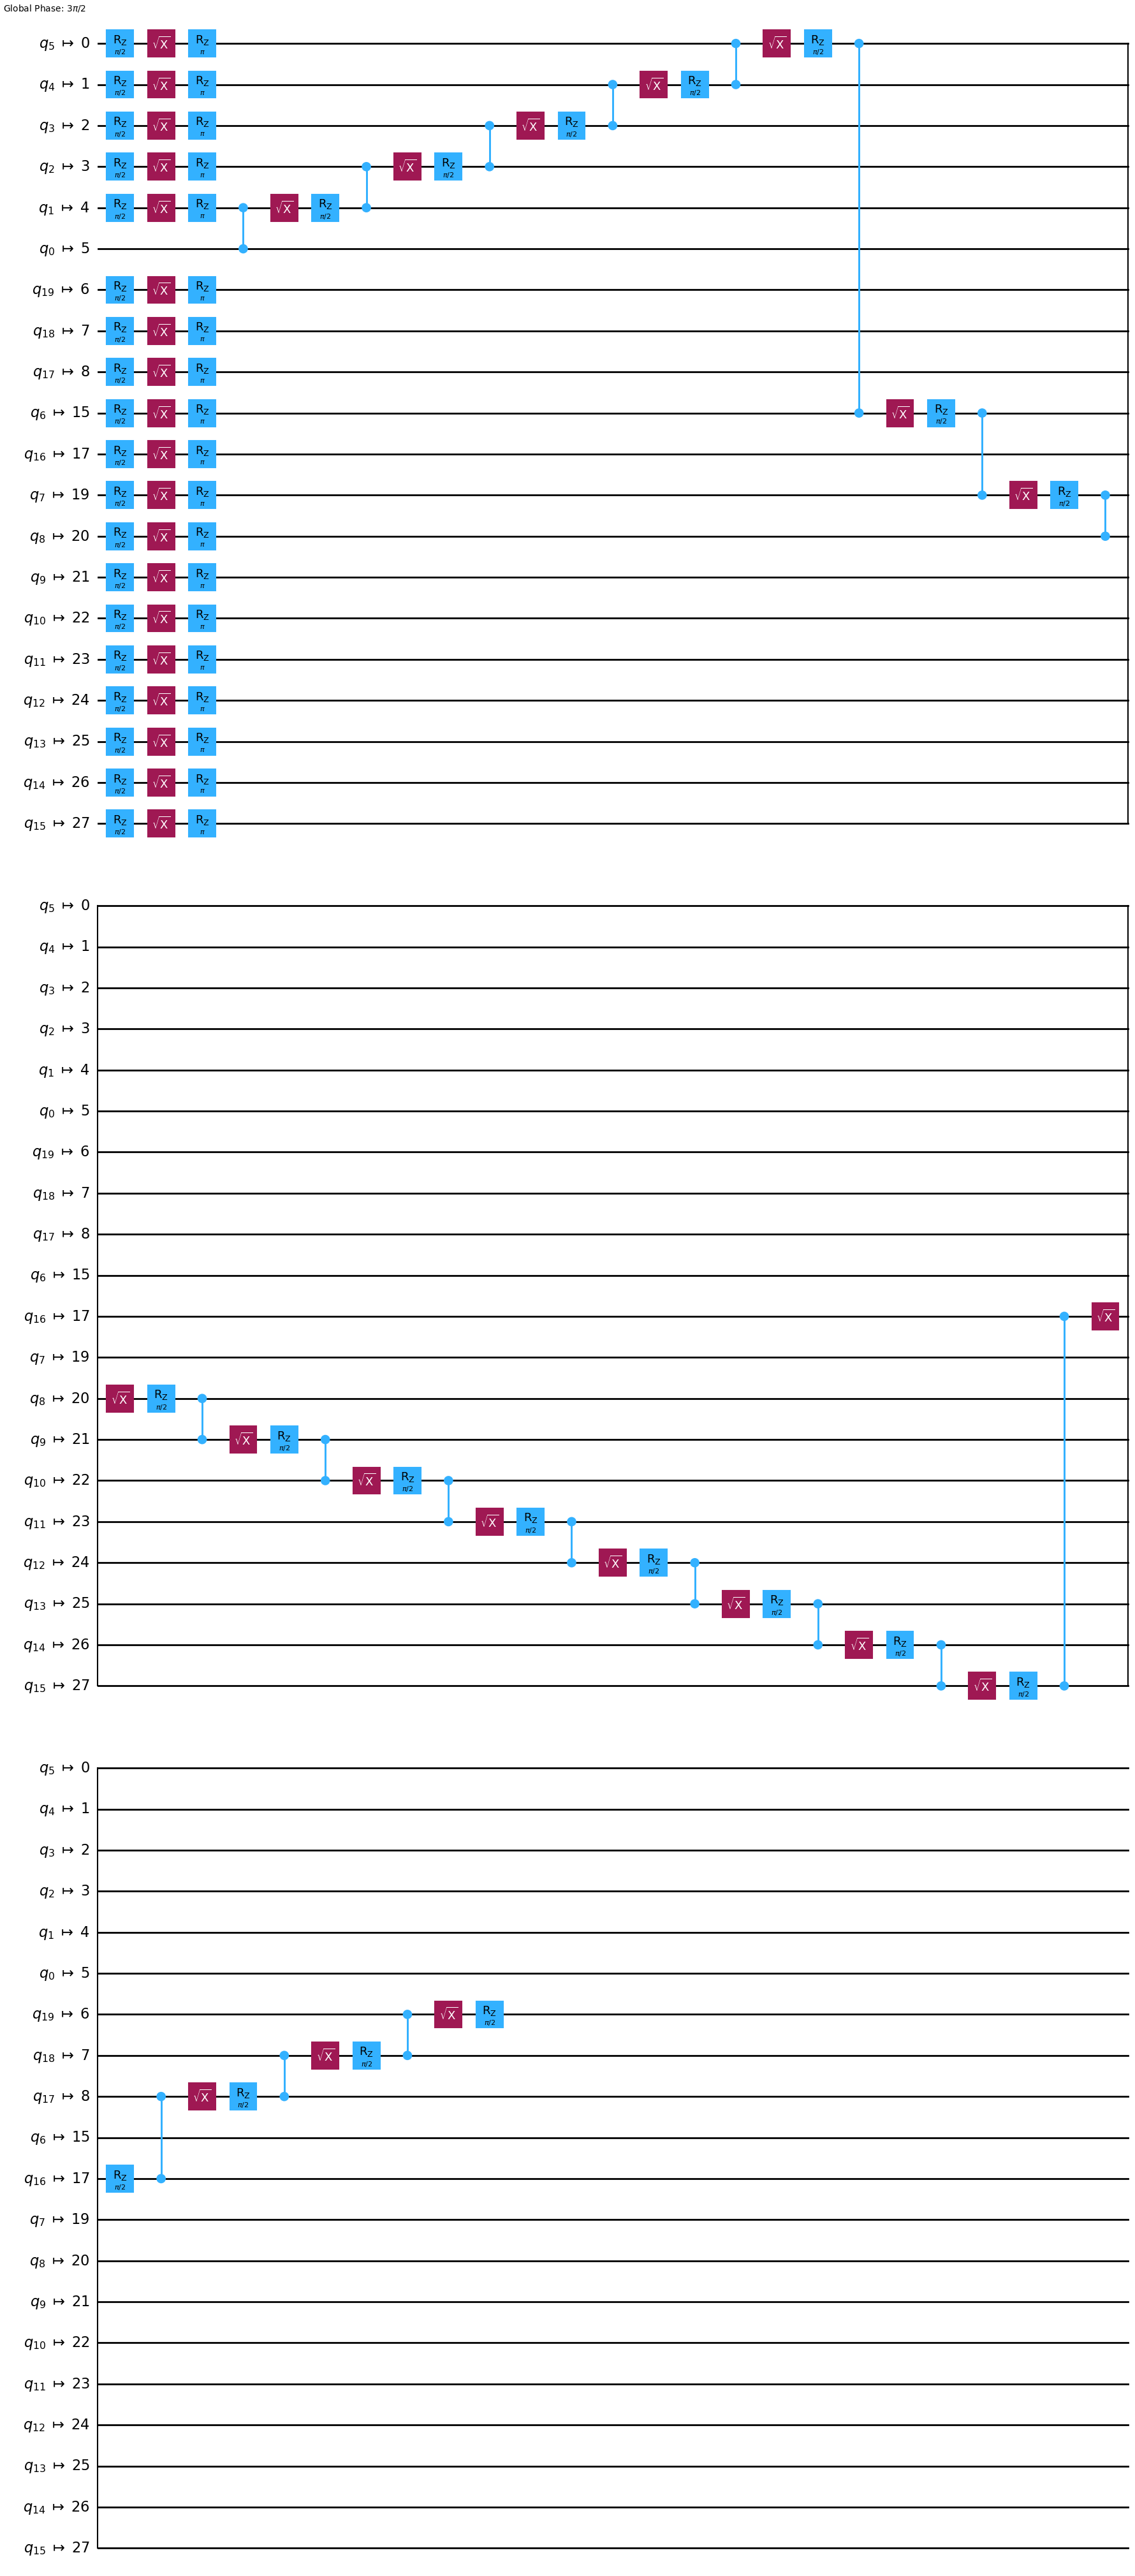

In [33]:
transpiled_baseline.draw("mpl")

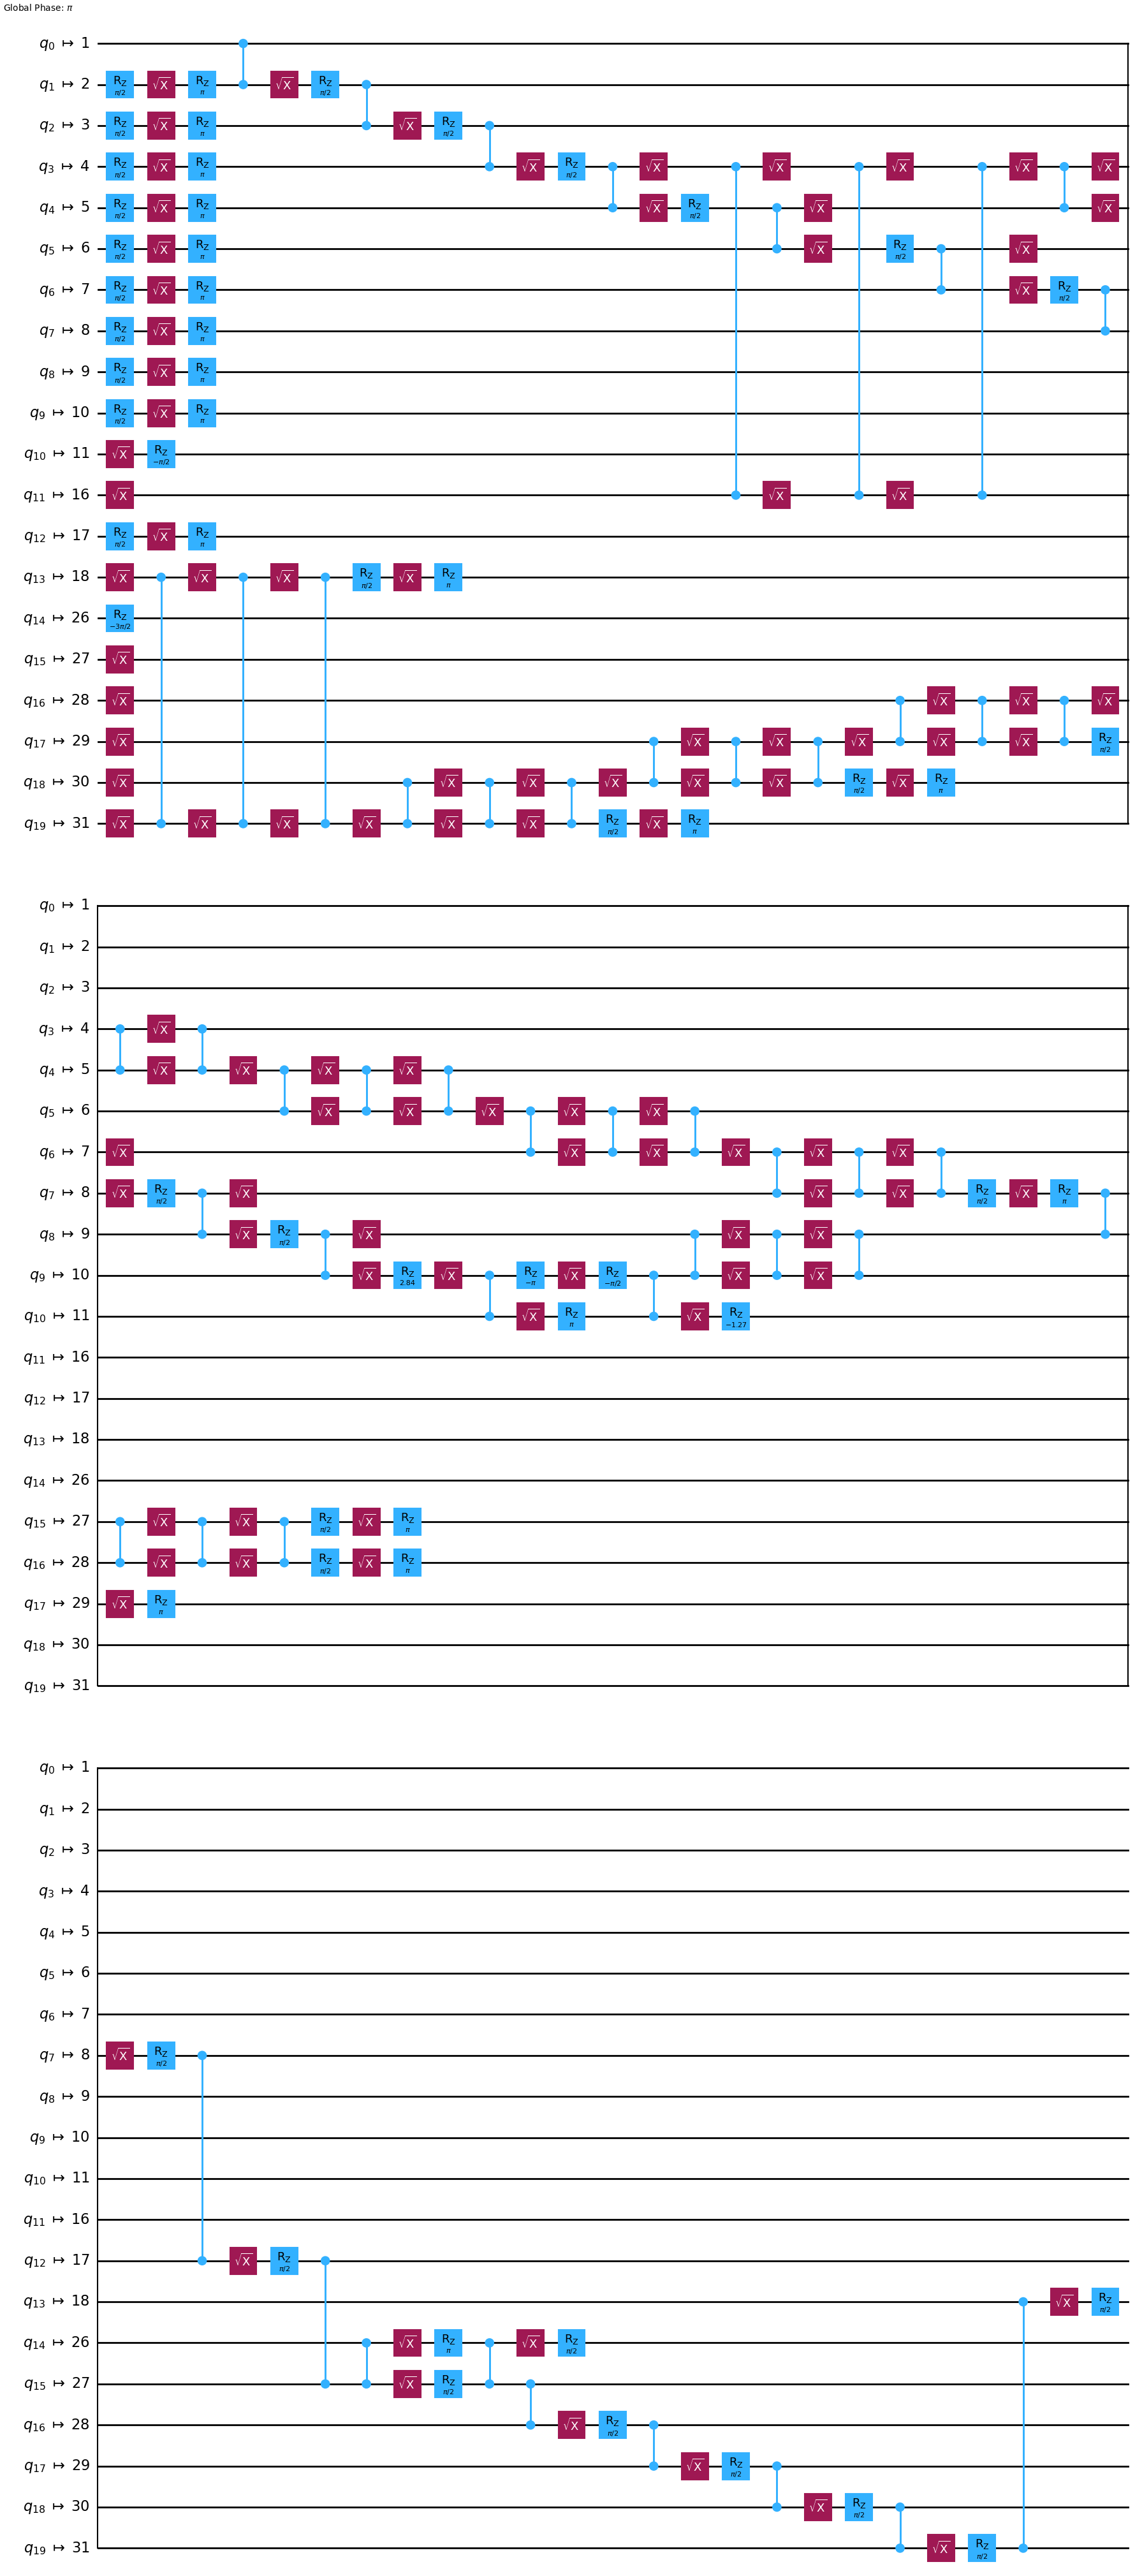

In [34]:
transpiled_pruned.draw("mpl")